<a href="https://colab.research.google.com/github/sayaleepande/GenAI/blob/main/M10_Lab1_LangGraph_Intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div style="font-family: 'Segoe UI', sans-serif; background-color: #f4faff; padding: 20px; border-radius: 12px; border-left: 6px solid #3399ff; color: #1a1a1a">

  <h1 style="color: #0066cc;">🚀 <strong>LangGraph Lab: Part 1: Introduction</strong></h1>
  <p><strong style="color: #3399ff;">Prof. Dehghani</strong></p>

  <h2 style="color: #004c99;">🔹 Building More Controllable LLM Agents with LangGraph</h2>

  <h3 style="color: #0059b3;">🔷 Introduction</h3>
  <p>
    <strong>LangGraph</strong> is a framework designed for building <strong>agent and multi-agent applications</strong> with structured control.
    While large language models (LLMs) are powerful, they often require <strong>more precise workflows</strong> to ensure reliability.
  </p>
  <p>
    Many real-world applications need agents to follow <strong>specific steps</strong>, such as always calling a certain tool first or adjusting their prompts
    based on the current state. Traditional agent frameworks may not provide enough control for these scenarios.
    <strong>LangGraph</strong> introduces a <em>graph-based approach</em> that allows developers to define structured workflows while still benefiting from LLM flexibility.
  </p>
  <p>
    This lab is adapted from the
    <a href="https://academy.langchain.com/courses/intro-to-langgraph" target="_blank" style="color:#0066cc;">
      LangChain Academy's Intro to LangGraph
    </a>, which provides additional details and use cases.
  </p>

  <h3 style="color: #0059b3;">🎯 Lab Objectives</h3>
  <ul>
    <li>The role of <strong>graphs</strong> in LLM-based agent workflows</li>
    <li>How to define <strong>nodes</strong> (decision points) and <strong>edges</strong> (paths) in LangGraph</li>
    <li>Implementing an <strong>agent with controlled decision-making</strong></li>
    <li>Exploring <strong>multi-agent interactions</strong> within a structured framework</li>
  </ul>

  <h3 style="color: #0059b3;">⚙️ Getting Started</h3>
  <p>Run the following cell to install the required libraries:</p>
</div>


In [12]:
# ++++ 🛠️ Minimal Install for LangGraph-based Graph Workflows (No LLMs)

%%capture --no-stderr
!pip install --quiet -U langgraph          # 🔄 Core framework for graph-based stateful workflows
!pip install --quiet -U langchain_core     # 🧠 Core utilities and types required by LangGraph


In [13]:
# ++++ 📦 Standard Imports
import os
from IPython.display import display, HTML
import json

In [14]:
# 🖨️ pretty_print(): Reusable HTML display function for model outputs
def pretty_print(text, title="🤖 Model Response"):
    """
    Display model response in styled HTML block.
    Handles bulleted lists and line breaks.
    """
    lines = text.strip().split('\n')
    is_bulleted = all(line.strip().startswith(("-", "•", "*")) for line in lines if line.strip())

    if is_bulleted:
        list_items = ''.join(f"<li>{line.lstrip('-•* ').strip()}</li>" for line in lines if line.strip())
        content_html = f"<ul style='margin-top: 6px;'>{list_items}</ul>"
    else:
        content_html = text.replace("\n", "<br>")  # fallback for plain lines

    display(HTML(f"""
    <div style="background-color:#f8f9fc; border-left:5px solid #4285f4;
                padding:16px; margin-top:16px; font-family:'Segoe UI', sans-serif;
                color:#202124; line-height:1.6;">
      <strong>{title}</strong><br><br>
      {content_html}
    </div>
    """))

<div style="background-color:#f8f9fc; border-left:5px solid #4285f4;
            padding:16px; margin-top:16px; font-family:'Segoe UI', sans-serif;
            color:#202124; line-height:1.6;">

  <strong>🧩 The Simplest Graph</strong><br><br>

  Let's build a simple graph with <strong>three nodes</strong> and <strong>one conditional edge</strong>.
  This structure allows an agent to make a decision at a branching point, directing the flow based on predefined conditions.<br><br>

  <img src="https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dba5f465f6e9a2482ad935_simple-graph1.png" width="600" style="border-radius: 8px; border: 1px solid #ccc;"/><br><br>

  This example demonstrates how <strong>LangGraph</strong> enables structured decision-making while maintaining flexibility.
</div>


<div style="background-color:#f8f9fc; border-left:5px solid #4285f4;
            padding:20px; margin-top:16px; font-family:'Segoe UI', sans-serif;
            color:#202124; line-height:1.6;">

  <h3 style="margin-top:0;">🛠️ Understanding Graph Components</h3>

  LangGraph workflows consist of <strong>three main components</strong>: <em>State, Nodes, and Edges</em>. Each plays a key role in defining how information flows through the graph.

  <hr style="margin:18px 0;">

  <h4>🧠 State</h4>
  <p>
    The <strong>State</strong>
    (<a href="https://langchain-ai.github.io/langgraph/concepts/low_level/#state" target="_blank">docs</a>)
    acts as the <strong>shared memory</strong> of the graph, storing data that nodes can read and modify.
  </p>
  <ul>
    <li>Every <em>node and edge</em> interacts with the state.</li>
    <li>Defined using <code>TypedDict</code> from Python’s <code>typing</code> module.</li>
    <li>Nodes modify the state by updating specific keys.</li>
  </ul>

  <hr style="margin:18px 0;">

  <h4>🔵 Nodes</h4>
  <p>
    A <strong>Node</strong>
    (<a href="https://langchain-ai.github.io/langgraph/concepts/low_level/#nodes" target="_blank">docs</a>)
    is a simple <strong>Python function</strong> that processes the state.
  </p>
  <ul>
    <li>The <strong>first argument</strong> of a node is always the <em>state</em>.</li>
    <li>Nodes can read and modify the state via keys like <code>state['graph_state']</code>.</li>
    <li>Return values update the state;
        <a href="https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers" target="_blank">reducers</a>
        handle value replacement.</li>
  </ul>

  <hr style="margin:18px 0;">

  <h4>🔀 Edges</h4>
  <p>
    An <strong>Edge</strong>
    (<a href="https://langchain-ai.github.io/langgraph/concepts/low_level/#edges" target="_blank">docs</a>)
    connects nodes and controls how data flows between them.
  </p>
  <ul>
    <li><strong>Normal Edges</strong> → Always flow to the next node (e.g., <code>node_1 → node_2</code>).</li>
    <li><strong>Conditional Edges</strong>
        (<a href="https://langchain-ai.github.io/langgraph/concepts/low_level/#conditional-edges" target="_blank">docs</a>)
        → Use logic to determine the next node.</li>
  </ul>
  <p>
    Conditional edges <em>act


In [15]:
# 📦 Import TypedDict and Literal for defining structured state
from typing_extensions import TypedDict  # For backward-compatible typed dicts
from typing import Literal               # For fixed value types
import random                            # For simulating mood selection

# 🎯 Define the State Schema
# The state acts as shared memory for the graph.
# It stores a key-value pair where 'graph_state' holds a string that evolves as nodes modify it.
class State(TypedDict):
    graph_state: str  # Tracks the sentence as it builds through the nodes


# 🔵 Define Nodes
# Each node modifies the 'graph_state' by appending its own text.
# Nodes simulate a simple sentence-building process.

def node_1(state: State) -> State:
    """Node 1 initializes the sentence with 'I am'."""
    print("--- Node 1 ---")
    return {"graph_state": state["graph_state"] + " I am"}

def node_2(state: State) -> State:
    """Node 2 completes the sentence with 'happy!'."""
    print("--- Node 2 ---")
    return {"graph_state": state["graph_state"] + " happy!"}

def node_3(state: State) -> State:
    """Node 3 completes the sentence with 'sad!'."""
    print("--- Node 3 ---")
    return {"graph_state": state["graph_state"] + " sad!"}


# 🔀 Define the Decision Function
# This function decides whether to send the state to Node 2 or Node 3.
# It randomly picks between the two, simulating an unpredictable emotional outcome.

def decide_mood(state: State) -> Literal["node_2", "node_3"]:
    """Randomly selects between Node 2 (happy) and Node 3 (sad)."""
    return "node_2" if random.random() < 0.5 else "node_3"


## 🚀 Graph Construction  

Now, it's time to build the graph using the **components** defined earlier. The **StateGraph class** is used to create and manage the graph structure.  

### 🏗️ Steps to Build the Graph  
1. **Initialize the Graph** → Create a `StateGraph` using the `State` class.  
2. **Add Nodes and Edges** → Define how the graph flows.  
3. **Use Special Nodes**:  
   - **`START` Node** → Sends user input into the graph.  
   - **`END` Node** → Represents a terminal state.  
4. **Compile the Graph** → Ensures structural validity.  
5. **Visualize** → Convert it into a **Mermaid diagram** for better understanding.  

### 🔗 Reference Table  

| Concept       | Documentation Link |
|--------------|------------------|
| StateGraph Class | [StateGraph Docs](https://langchain-ai.github.io/langgraph/concepts/low_level/#stategraph) |
| START Node   | [START Node Docs](https://langchain-ai.github.io/langgraph/concepts/low_level/#start-node) |
| END Node     | [END Node Docs](https://langchain-ai.github.io/langgraph/concepts/low_level/#end-node) |
| Graph Compilation | [Compiling a Graph](https://langchain-ai.github.io/langgraph/concepts/low_level/#compiling-your-graph) |
| Mermaid Diagrams | [Mermaid Docs](https://github.com/mermaid-js/mermaid) |

This approach makes the graph more **structured, adaptable, and easy to debug**.  


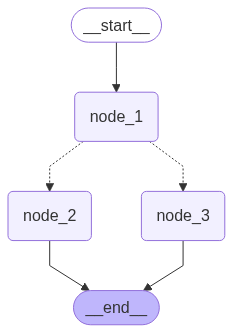

In [16]:
# ++++ 🧩 Build and Visualize the LangGraph

# 📦 Import display utilities and graph construction tools
from IPython.display import Image, display  # For rendering the graph diagram
from langgraph.graph import StateGraph, START, END  # Core LangGraph components

# 🏗️ Initialize the Graph Builder with the defined State schema
builder = StateGraph(State)

# 🔵 Add Nodes: These are the functional units of the graph
builder.add_node("node_1", node_1)  # Starts the sentence
builder.add_node("node_2", node_2)  # Appends "happy!"
builder.add_node("node_3", node_3)  # Appends "sad!"

# 🔗 Define Graph Flow: Edges between nodes
builder.add_edge(START, "node_1")  # Entry point → node_1
builder.add_conditional_edges("node_1", decide_mood)  # Conditional path → node_2 or node_3
builder.add_edge("node_2", END)  # Happy path → END
builder.add_edge("node_3", END)  # Sad path → END

# ✅ Compile the graph for execution
graph = builder.compile()

# 🖼️ Visualize the final graph structure
display(Image(graph.get_graph().draw_mermaid_png()))


<div style="background-color:#f8f9fc; border-left:5px solid #4285f4;
            padding:16px; margin-top:16px; font-family:'Segoe UI', sans-serif;
            color:#202124; line-height:1.6;">

  <h3 style="margin-top:0;">🧮 Graph Invocation</h3>

  The compiled graph follows the
  <a href="https://python.langchain.com/docs/concepts/runnables/" target="_blank">runnable protocol</a>,
  providing a standardized way to execute LangChain components.

  <br><br>
  The <code>invoke</code> method is used to start execution, with an input dictionary like
  <code>{"graph_state": "Hi, this is Lance."}</code> setting the initial state. The graph begins at the
  <code>START</code> node and moves through the defined nodes (<code>node_1</code>, <code>node_2</code>,
  <code>node_3</code>) based on the control flow.

  <br><br>
  A conditional edge determines whether the execution moves from <code>node_1</code> to <code>node_2</code> or
  <code>node_3</code>, following a 50/50 probability rule. Each node processes the current state, modifies the
  <code>graph_state</code> value, and returns the updated state.

  <br><br>
  The execution continues along the directed edges until it reaches the <code>END</code> node, where the final
  graph state is returned.
</div>


In [17]:
pretty_print(graph.invoke({"graph_state": "Hi, this is Lance."})["graph_state"], title="🧠 Mood Result")


--- Node 1 ---
--- Node 2 ---


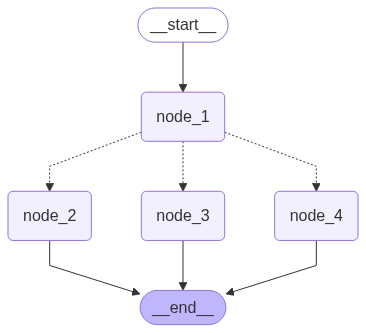

--- Node 1 ---
--- Node 3 ---


--- Node 1 ---
--- Node 4 ---


--- Node 1 ---
--- Node 3 ---


In [18]:
# ++++ 😕 Add a New Mood Option ("confused!") and Test the Updated LangGraph

# ✅ 1. Define the new mood node
def node_4(state: State) -> State:
    """Node 4 completes the sentence with 'confused!'."""
    print("--- Node 4 ---")
    return {"graph_state": state["graph_state"] + " confused!"}

# ✅ 2. Update the decision logic to include the new node
def decide_mood(state: State) -> Literal["node_2", "node_3", "node_4"]:
    r = random.random()
    if r < 0.33:
        return "node_2"
    elif r < 0.66:
        return "node_3"
    return "node_4"

# ✅ 3. Rebuild the full graph with the new mood included
builder = StateGraph(State)

builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)
builder.add_node("node_4", node_4)  # Register the new node

builder.add_edge(START, "node_1")
builder.add_conditional_edges("node_1", decide_mood)
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)
builder.add_edge("node_4", END)  # Connect new mood to END

# ✅ 4. Compile the updated graph
graph = builder.compile()

# 🖼️ 5. Visualize the updated graph
display(Image(graph.get_graph().draw_mermaid_png()))

# 🧪 6. Invoke the graph multiple times to see different mood outcomes
for i in range(3):
    result = graph.invoke({"graph_state": f"Hi, this is Lance {i+1}."})
    pretty_print(result["graph_state"], title=f"🧠 Mood Result #{i+1}")


<div style="background-color:#f8f9fc; border-left:5px solid #3399ff;
            padding:18px; margin-top:16px; font-family:'Segoe UI', sans-serif;
            color:#202124; line-height:1.6;">

  <h2 style="margin-top:0;">✈️ Airport Security Screening Simulation</h2>
  <h4>🎓 <em>LangGraph Hands-On Exercise</em></h4>

  <p>
    In this hands-on activity, you'll simulate an <strong>airport security screening process</strong> using the
    <strong>LangGraph</strong> framework. Passengers arrive at security and are categorized into different paths:
  </p>

  <ul>
    <li><strong>TSA PreCheck (20%)</strong> → Fast screening with minimal delay</li>
    <li><strong>Regular Screening (80%)</strong> → Standard security check</li>
    <li><strong>Additional Screening (10% of Regular)</strong> → Extra manual inspection before gate entry</li>
  </ul>

  <p>Here’s a visual representation of the screening logic:</p>

  <img src="https://www.dropbox.com/scl/fi/o3ipy33svrcg64myu0u0s/AirPort_Security.png?rlkey=d6hc4bqdphzducnixba9ic2ai&dl=1"
       width="600" style="border-radius: 8px; border: 1px solid #ccc; margin-top:10px;" />

  <hr style="margin:20px 0;">

  <h4>🧪 Task: Complete the Missing Code</h4>
  <p>
    Your goal is to <strong>fill in the placeholders</strong> (e.g., <code>------</code>) to build a working LangGraph simulation.
  </p>
  <ul>
    <li>Define node functions for <code>precheck_screening</code>, <code>regular_screening</code>, and <code>manual_check</code>.</li>
    <li>Write a <code>screening_decision()</code> function to route passengers correctly.</li>
    <li>Register the nodes and connect them with edges in the graph.</li>
  </ul>

  <p style="margin-top:12px;">
    Once complete, you will be able to run <code>graph.invoke({"passenger_id": "P123"})</code> to simulate a screening outcome.
  </p>
</div>


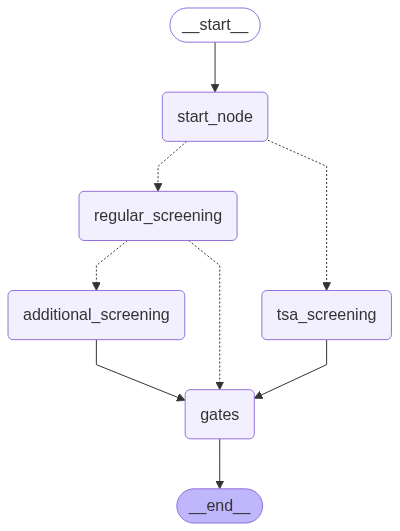

🛫 Passenger arrives at security.
🔵 Passenger assigned to Regular Screening.
🔎 Regular passenger goes through standard screening.
✅ Passenger cleared security after regular screening.
✅ Passenger cleared security. Proceeding to Gates!


{'passenger_type': 'Hi, this is the airport security screening'}

In [20]:
from typing_extensions import TypedDict
from typing import Literal
import random
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END


# 🎯 Define the State Schema
class AirportState(TypedDict):
    passenger_type: str  # Tracks whether passenger is Regular or TSA PreCheck

# 🔵 Define Nodes
def start_node(state: AirportState) -> AirportState:
    """Initial step where a passenger enters security."""
    print("🛫 Passenger arrives at security.")
    return state

def tsa_screening(state: AirportState) -> AirportState:
    """TSA PreCheck passengers go through expedited screening."""
    print("🟢 TSA PreCheck passenger goes through expedited screening.")
    return state

def regular_screening(state: AirportState) -> AirportState:
    """Regular passengers go through standard screening."""
    print("🔎 Regular passenger goes through standard screening.")
    return state

def additional_screening(state: AirportState) -> AirportState:
    """Additional screening for some regular passengers."""
    print("⚠️ Additional screening required for passenger.")
    return state

def gates(state: AirportState) -> AirportState:
    """All passengers proceed to the boarding gates."""
    print("✅ Passenger cleared security. Proceeding to Gates!")
    return state

# 🔀 Define the First Decision Function (TSA or Regular)
def assign_passenger_type(state: AirportState) -> Literal["tsa_screening", "regular_screening"]:
    """Randomly assigns passengers to TSA PreCheck (20%) or Regular (80%)."""
    if random.random() < 0.20:
        print("🟢 Passenger assigned to TSA PreCheck.")
        return "tsa_screening"
    else:
        print("🔵 Passenger assigned to Regular Screening.")
        return "regular_screening"

# 🔀 Define the Second Decision Function (Regular -> Additional Screening or Gates)
def additional_screening_decision(state: AirportState) -> Literal["additional_screening", "gates"]:
    """10% of regular passengers go to additional screening, while 90% proceed to gates."""
    if random.random() < 0.10:
        print("⚠️ Passenger selected for additional screening.")
        return "additional_screening"
    else:
        print("✅ Passenger cleared security after regular screening.")
        return "gates"

# 🏗️ Build the Graph
builder = StateGraph(AirportState)

# 🔵 Add Nodes
builder.add_node("start_node", start_node)
builder.add_node("tsa_screening", tsa_screening)
builder.add_node("regular_screening", regular_screening)
builder.add_node("additional_screening", additional_screening)
builder.add_node("gates", gates)

# 🔗 Define Graph Flow (Edges)
builder.add_edge(START, "start_node")
builder.add_conditional_edges("start_node", assign_passenger_type)
builder.add_edge("tsa_screening", "gates")
builder.add_conditional_edges("regular_screening", additional_screening_decision)
builder.add_edge("additional_screening", "gates")
builder.add_edge("gates", END)

# ✅ Compile the Graph
graph = builder.compile()

# 🖼️ Visualize the Graph
display(Image(graph.get_graph().draw_mermaid_png()))

# 🚀 Run the Graph

graph.invoke({"passenger_type":"Hi, this is the airport security screening"})


In [21]:
# # 🔄 Test your code: Refresh this cell to see how the model works on different scenarios

graph.invoke({"passenger_type":"Hi, this is the airport security screening"})

🛫 Passenger arrives at security.
🟢 Passenger assigned to TSA PreCheck.
🟢 TSA PreCheck passenger goes through expedited screening.
✅ Passenger cleared security. Proceeding to Gates!


{'passenger_type': 'Hi, this is the airport security screening'}